# REEDs PCA Baselines for Si & CdTe

ReEDS installation projections from the Solar Futures Study, published by DOE on 2021.

Scenario Interest: 
o	95-by-35+Elec.Adv+DR ,  a.k.a. "Solar Futures Decarbonization + Electrification scenario"

This code performs three Methods to output files for the Mass Flows:
<ol>
    <li> PCA original data by ReEDS </li>
    <li> PCA data reordered based on ascending production up to 2035, and then descending, </li>
    <li> PCA data calculated with an exponencial that mathces the cumulative 2035 and 2050 targets </li>
</ol>

In [1]:
import PV_ICE
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
import os
from pathlib import Path

cwd = os.getcwd()
testfolder = os.path.join(cwd, 'TEMP')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)
print ("Your simulation will be stored in %s" % testfolder)


Your simulation will be stored in C:\Users\sayala\Documents\GitHub\PV_ICE\docs\tutorials\13 - US Spatial Analysis for US Si & CdTe\TEMP


In [3]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("PV_ICE version ", PV_ICE.__version__)

Working on a  Windows 10
Python version  3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Pandas version  2.2.2
PV_ICE version  v0.2.0+642.g15d5a61.dirty


In [4]:
baselinesFolder = Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines'
baselinesFolder

WindowsPath('C:/Users/sayala/Documents/GitHub/PV_ICE/PV_ICE/baselines')

## 1. Create Scenarios

### A. Reading a standard ReEDS output file

In [5]:
reedsFile = os.path.join(baselinesFolder, 'SupportingMaterial', 'December Core Scenarios ReEDS Outputs Solar Futures v3a.xlsx')
print ("Input file is stored in %s" % reedsFile)


Input file is stored in C:\Users\sayala\Documents\GitHub\PV_ICE\PV_ICE\baselines\SupportingMaterial\December Core Scenarios ReEDS Outputs Solar Futures v3a.xlsx


In [6]:
REEDSInput = pd.read_excel(reedsFile,
#                        sheet_name="new installs PV (2)")
                       sheet_name="new installs PV")

#index_col=[0,2,3]) #this casts scenario, PCA and State as levels


### B. Save Input Files by PCA

#### Create a copy of the REEDS Input and modify structure for PCA focus

In [7]:
rawdf = REEDSInput.copy()
rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True) #tech=pvtotal from "new installs PV sheet", so can drop
rawdf.set_index(['Scenario','Year','PCA'], inplace=True)
rawdf.head(21)

Capacity (GW)
Scenario     Year PCA               
95-by-35.Adv 2010 p1        0.000017
             2011 p1        0.005158
             2012 p1        0.005158
             2013 p1        0.007146
             2014 p1        0.007146
             2015 p1        0.018253
             2016 p1        0.018253
             2017 p1        0.019460
             2018 p1        0.019460
             2019 p1        0.036320
             2020 p1        0.036320
             2021 p1        0.002434
             2022 p1        0.002434
             2023 p1        0.010066
             2024 p1        0.010066
             2025 p1        0.049445
             2026 p1        0.049445
             2027 p1        0.051342
             2028 p1        0.051342
             2029 p1        0.105931
             2030 p1        0.105931

#### Loading Module Baseline. 

In [13]:
r1 = PV_ICE.Simulation(name='Simulation1', path=testfolder)
r1.createScenario(name='cSi', massmodulefile= 'baseline_modules_mass_US.csv', energymodulefile='baseline_modules_energy.csv')  # this is technically cSi, but we haven't renamed the baseline.
baseline = r1.scenario['cSi'].dataIn_m
baseline = baseline.drop(columns=['new_Installed_Capacity_[MW]'])
baseline.set_index('year', inplace=True)
baseline.index = pd.PeriodIndex(baseline.index, freq='Y')  # Y -- yearly
baseline.head()

r1.createScenario(name='CdTe', massmodulefile='baseline_modules_mass_US_CdTe.csv', energymodulefile='baseline_modules_energy.csv')
baselineCdTe = r1.scenario['CdTe'].dataIn_m
baselineCdTe = baselineCdTe.drop(columns=['new_Installed_Capacity_[MW]'])
baselineCdTe.set_index('year', inplace=True)
baselineCdTe.index = pd.PeriodIndex(baselineCdTe.index, freq='Y')  # Y -- yearly

path = C:\Users\sayala\Documents\GitHub\PV_ICE\docs\tutorials\13 - US Spatial Analysis for US Si & CdTe\TEMP
Baseline folder directed to default:  C:\Users\sayala\Documents\GitHub\PV_ICE\PV_ICE\baselines


In [14]:
r1.scenMod_noCircularity() 

#### For each Scenario and for each PCA, combine with baseline and save as input file

In [15]:
#### Set header dynamically
import csv

massmodulefile = os.path.join(baselinesFolder, 'baseline_modules_mass_US.csv')

with open(massmodulefile, newline='') as f:
    reader = csv.reader(f)
    row1 = next(reader)  # gets the first line
    row2 = next(reader)  # gets the first line

row11 = 'year'
for x in row1[1:]:
    row11 = row11 + ',' + x 

row22 = 'year'
for x in row2[1:]:
    row22 = row22 + ',' + x 

#### Load MarketShare File

In [16]:
marketsharefile = os.path.join(baselinesFolder,'SupportingMaterial','output_USA_Si_marketshare.csv')
marketshare = pd.read_csv(marketsharefile)
marketshare = marketshare[marketshare['Year']>=2010].reset_index(drop=True)
marketshare.set_index('Year', inplace=True)
marketshare.rename(columns={'All_Marketshare':'cSi Market Share'}, inplace=True)
marketshare.loc[2021:,'cSi Market Share'] = 0.81 # Values only go to 2020 at the moment; setting fixed value to same as 2020
marketshare['CdTe Market Share'] = 1 - marketshare['cSi Market Share']


In [17]:
# Hack for plots.
sparkplot = True
xvals = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
             '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025',
             '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033',
             '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041',
             '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049',
             '2050']
plt.rcParams.update({'font.size': 8})

Methods to smooth projected capacity increases:
1. Method 1: Uses the raw regionalized capacity by ReEEDS, this creates a very uneven peak of wastes.
2. Method 2: Uses ordered wastes between 2021 to 2035 and 2046 to 2050. Still creates unrealistic peaks.
3. Method 3: Uses the cummulative capacity between 2021 to 2035 and 2034 to 2050 to create a logarithmic growth of waste (this method is being tested, not validated yet, and subjected to ongoing changes).

In [18]:
Method = 1 

In [14]:
for ii in range (len(rawdf.unstack(level=1))):
    PCA = rawdf.unstack(level=1).iloc[ii].name[1] #This one iterates over the pca names: p1 to p99
    SCEN = rawdf.unstack(level=1).iloc[ii].name[0] #This one iterates over all scenario names: 
                                                   # 95-by-35+Elec.Adv, 95-by-35.Adv, Reference.Adv+DR, etc
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_cSI_'+PCA +'.csv' #These lines, 2 to 5 will allow to make file names
    subtestfolder = os.path.join(testfolder, 'PCAs_Method1') # Create folder of the scenarios
    if not os.path.exists(subtestfolder): # Create folder if it doen's exist
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    A = rawdf.unstack(level=1).iloc[ii]
    A = A.droplevel(level=0)
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='Y')
    A = pd.DataFrame(A)
    B = A.copy()
    B['new_Installed_Capacity_[MW]'] = B['new_Installed_Capacity_[MW]'] * marketshare['cSi Market Share'].values
    B['new_Installed_Capacity_[MW]'] = B['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.

    if Method == 2:
        # Sort Ascending 2022 to 2035 new_Installed_Capacity_[MW]
        # Sort Descending 2035 to 2050 new_Installed_Capacity_[MW]
        sortedB = (list(B.iloc[0:12]['new_Installed_Capacity_[MW]'].values) + list(B.iloc[12:25]['new_Installed_Capacity_[MW]'].sort_values().values)
        +list(B.iloc[25::]['new_Installed_Capacity_[MW]'].sort_values(ascending=False).values))
        sortedBdf = pd.DataFrame(sortedB, index = A.index, columns =['new_Installed_Capacity_[MW]'])
        B = sortedBdf.reindex(A.index)
    elif Method == 3:   
        # LINEAR
        # some sort of exponential growth that still sums up tthe correct capacity would be ideal.
        # Currently jsut doing a linear division per year per location
        # LINEAR
        yearly2035 = B.iloc[12:26]['new_Installed_Capacity_[MW]'].sum()/len(B.iloc[12:26])
        yearly2050 = B.iloc[26::]['new_Installed_Capacity_[MW]'].sum()/len(B.iloc[26::])
        n2022= B.iloc[12].name
        n2035= B.iloc[25].name
        n2036= B.iloc[26].name
        n2050= B.iloc[-1].name
        B.loc[n2022:n2035, 'new_Installed_Capacity_[MW]' ] = yearly2035
        B.loc[n2036:n2050, 'new_Installed_Capacity_[MW]' ] = yearly2050

    # Add other columns
    B = pd.concat([B, baseline.reindex(A.index)], axis=1)
    
    header = row11 + '\n' + row22 + '\n'
    
    # SPARK PLOT
    if sparkplot:
        sparkplotfolder = os.path.join(subtestfolder, 'SPARKPLOTS')
        if not os.path.exists(sparkplotfolder):
            os.makedirs(sparkplotfolder)

        fig, axs = plt.subplots(figsize=(8, 5), facecolor='w', edgecolor='k')
        plt.plot(xvals, B['new_Installed_Capacity_[MW]'].values)
        plt.xticks(rotation=45)
        figtitle = 'PV ICE ' + SCEN + ' Baseline_Csi_'+PCA+'.png'
        fig.savefig(os.path.join(sparkplotfolder, figtitle), dpi=600)
        plt.close(fig) # This avoids the figure from displayig and getting all the warnings
    
    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        B.to_csv(ict, header=False)
    
    filetitle = SCEN+'_CdTe_'+PCA +'.csv'
    filetitle = os.path.join(subtestfolder, filetitle)

    B = A.copy()
    B['new_Installed_Capacity_[MW]'] = B['new_Installed_Capacity_[MW]'] * marketshare['CdTe Market Share'].values
    B['new_Installed_Capacity_[MW]'] = B['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    if Method == 2:
        sortedB = (list(B.iloc[0:12]['new_Installed_Capacity_[MW]'].values) + list(B.iloc[12:25]['new_Installed_Capacity_[MW]'].sort_values().values)
        +list(B.iloc[25::]['new_Installed_Capacity_[MW]'].sort_values(ascending=False).values))
        sortedBdf = pd.DataFrame(sortedB, index = A.index, columns =['new_Installed_Capacity_[MW]'])
        B = sortedBdf.reindex(A.index)
    elif Method == 3:   
        # LINEAR
        # some sort of exponential growth that still sums up tthe correct capacity would be ideal.
        # Currently jsut doing a linear division per year per location
        # LINEAR
        yearly2035 = B.iloc[12:26]['new_Installed_Capacity_[MW]'].sum()/len(B.iloc[12:26])
        yearly2050 = B.iloc[26::]['new_Installed_Capacity_[MW]'].sum()/len(B.iloc[26::])
        n2022= B.iloc[12].name
        n2035= B.iloc[25].name
        n2036= B.iloc[26].name
        n2050= B.iloc[-1].name
        B.loc[n2022:n2035, 'new_Installed_Capacity_[MW]' ] = yearly2035
        B.loc[n2036:n2050, 'new_Installed_Capacity_[MW]' ] = yearly2050
    
    # Add other columns
    B = pd.concat([B, baseline.reindex(A.index)], axis=1)
    
    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        B.to_csv(ict, header=False)

print("Results saved on ", testfolder)

Results saved on  C:\Users\sayala\Documents\GitHub\PV_ICE\docs\tutorials\13 - US Spatial Analysis for US Si & CdTe\TEMP


In [15]:
print("Done")

Done


In [23]:
pwd

'C:\\Users\\sayala\\Documents\\GitHub\\PV_ICE\\docs\\tutorials\\13 - US Spatial Analysis for US Si & CdTe\\TEMP'

# CUMMULATIVE COUNTRY

In [7]:
rawdf = REEDSInput.copy()
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year'], inplace=True)
rawdf.head(21)

PCA State  Capacity (GW)
Scenario     Year                         
95-by-35.Adv 2010  p1    WA       0.000017
             2011  p1    WA       0.005158
             2012  p1    WA       0.005158
             2013  p1    WA       0.007146
             2014  p1    WA       0.007146
             2015  p1    WA       0.018253
             2016  p1    WA       0.018253
             2017  p1    WA       0.019460
             2018  p1    WA       0.019460
             2019  p1    WA       0.036320
             2020  p1    WA       0.036320
             2021  p1    WA       0.002434
             2022  p1    WA       0.002434
             2023  p1    WA       0.010066
             2024  p1    WA       0.010066
             2025  p1    WA       0.049445
             2026  p1    WA       0.049445
             2027  p1    WA       0.051342
             2028  p1    WA       0.051342
             2029  p1    WA       0.105931
             2030  p1    WA       0.105931

In [8]:
#df = rawdf.groupby(['Scenario','Year'])['Capacity (GW)'].sum(axis=0)
df = rawdf.groupby(['Scenario','Year'])['Capacity (GW)'].sum()


In [21]:
for ii in range (len(df.unstack(level=1))):
    SCEN = df.unstack(level=1).index[ii]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_cSi.csv'
    
    subtestfolder = os.path.join(testfolder, 'USA')
    if not os.path.exists(subtestfolder): # Create folder if it doen's exist
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    A = df.unstack(level=1).iloc[ii]
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='Y')
    A = pd.DataFrame(A)
    B = A.copy()
    B['new_Installed_Capacity_[MW]'] = B['new_Installed_Capacity_[MW]'] * marketshare['cSi Market Share'].values
    B['new_Installed_Capacity_[MW]'] = B['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.

    if Method == 2:
        # Sort Ascending 2022 to 2035 new_Installed_Capacity_[MW]
        # Sort Descending 2035 to 2050 new_Installed_Capacity_[MW]
        sortedB = (list(B.iloc[0:12]['new_Installed_Capacity_[MW]'].values) + list(B.iloc[12:25]['new_Installed_Capacity_[MW]'].sort_values().values)
        +list(B.iloc[25::]['new_Installed_Capacity_[MW]'].sort_values(ascending=False).values))
        sortedBdf = pd.DataFrame(sortedB, index = A.index, columns =['new_Installed_Capacity_[MW]'])
        B = sortedBdf.reindex(A.index)
    elif Method == 3:   
        # LINEAR
        # some sort of exponential growth that still sums up tthe correct capacity would be ideal.
        # Currently jsut doing a linear division per year per location
        # LINEAR
        yearly2035 = B.iloc[12:26]['new_Installed_Capacity_[MW]'].sum()/len(B.iloc[12:26])
        yearly2050 = B.iloc[26::]['new_Installed_Capacity_[MW]'].sum()/len(B.iloc[26::])
        n2022= B.iloc[12].name
        n2035= B.iloc[25].name
        n2036= B.iloc[26].name
        n2050= B.iloc[-1].name
        B.loc[n2022:n2035, 'new_Installed_Capacity_[MW]' ] = yearly2035
        B.loc[n2036:n2050, 'new_Installed_Capacity_[MW]' ] = yearly2050

    # Add other columns
    B = pd.concat([B, baseline.reindex(A.index)], axis=1)
    
    header = row11 + '\n' + row22 + '\n'
    
    # SPARK PLOT
    if sparkplot:
        sparkplotfolder = os.path.join(subtestfolder, 'SPARKPLOTS')
        if not os.path.exists(sparkplotfolder):
            os.makedirs(sparkplotfolder)

        fig, axs = plt.subplots(figsize=(8, 5), facecolor='w', edgecolor='k')
        plt.plot(xvals, B['new_Installed_Capacity_[MW]'].values)
        plt.xticks(rotation=45)
        figtitle = 'PV ICE ' + SCEN + ' Baseline_Csi_.png'
        fig.savefig(os.path.join(sparkplotfolder, figtitle), dpi=600)
        plt.close(fig) # This avoids the figure from displayig and getting all the warnings
    
    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        B.to_csv(ict, header=False)
    
    filetitle = SCEN+'_CdTe.csv'
    filetitle = os.path.join(subtestfolder, filetitle)

    B = A.copy()
    B['new_Installed_Capacity_[MW]'] = B['new_Installed_Capacity_[MW]'] * marketshare['CdTe Market Share'].values
    B['new_Installed_Capacity_[MW]'] = B['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    if Method == 2:
        sortedB = (list(B.iloc[0:12]['new_Installed_Capacity_[MW]'].values) + list(B.iloc[12:25]['new_Installed_Capacity_[MW]'].sort_values().values)
        +list(B.iloc[25::]['new_Installed_Capacity_[MW]'].sort_values(ascending=False).values))
        sortedBdf = pd.DataFrame(sortedB, index = A.index, columns =['new_Installed_Capacity_[MW]'])
        B = sortedBdf.reindex(A.index)
    elif Method == 3:   
        # LINEAR
        # some sort of exponential growth that still sums up tthe correct capacity would be ideal.
        # Currently jsut doing a linear division per year per location
        # LINEAR
        yearly2035 = B.iloc[12:26]['new_Installed_Capacity_[MW]'].sum()/len(B.iloc[12:26])
        yearly2050 = B.iloc[26::]['new_Installed_Capacity_[MW]'].sum()/len(B.iloc[26::])
        n2022= B.iloc[12].name
        n2035= B.iloc[25].name
        n2036= B.iloc[26].name
        n2050= B.iloc[-1].name
        B.loc[n2022:n2035, 'new_Installed_Capacity_[MW]' ] = yearly2035
        B.loc[n2036:n2050, 'new_Installed_Capacity_[MW]' ] = yearly2050
    
    # Add other columns
    B = pd.concat([B, baseline.reindex(A.index)], axis=1)
    
    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        B.to_csv(ict, header=False)

print("Results saved on ", testfolder)

Results saved on  C:\Users\sayala\Documents\GitHub\PV_ICE\docs\tutorials\13 - US Spatial Analysis for US Si & CdTe\TEMP


### Notes on explored methods 

<b> Method 4: </b>

Create a monotonically increasing deployment based on the cumulative betwen 2022 to 2035, and 2036 to 2050.

First calculates the cumulatives, then normalizes by 105 (for 14 years monotonically increasing) or 120 (for 15 years monotonically increasing), and then it does a loop to calculate each year


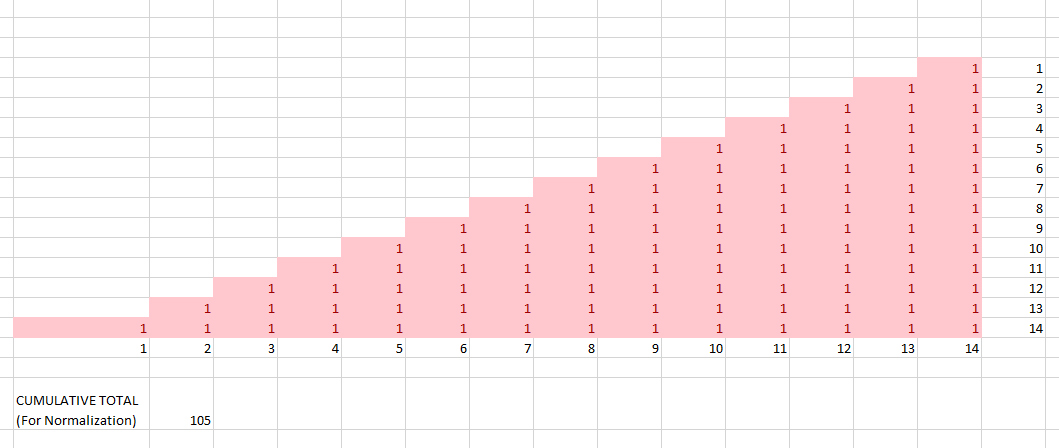
Other options based on this method: 
* increasing o the cumulative between 2022 to 2050 --> divide by 435 instead and set kk to loop 0 to 29 
* Or increasing between 2022 to 2035, and decreasing for 2036 to 2050 

<b> Method 5: (Heather) </b>

